## How to work with Climate Adaptation Digital Twin data on Earth Data Hub, standard resolution fields on a single level or surface: climatological analysis of temperature in Germany

This notebook will provide you guidance on how to access and use the [`https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr`](https://earthdatahub.destine.eu/collections/d1-climate-dt-ScenarioMIP-SSP3-7.0-IFS-NEMO/datasets/0001-standard-sfc) dataset. Access to this dataset is restricted to authorized user only via the the Data Cache Management service.

To access the data you need to instruct your tools (e.g. Xarray, Zarr...) to use the Data Cache Management service. This can be done by running the code snippets below. 

First, make sure you have an account on the [Destination Earth platform](https://platform.destine.eu). 
Then run the following cell, filling in your Destination Earth credentials and password when asked:

In [1]:
%%capture cap
%run ../cacheb/cacheb-authentication.py

Username:  n.masotti
Password:  ········


In [2]:
from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(cap.stdout)

⚠ **NOTE**: the temporary password is valid for a limited period of time and needs to be regenerated and reconfigured periodically by running the cells above.

### What you will learn:
* how to access and preview the dataset
* select and reduce the data
* plot the results
***

In this notebook we set two goals:

Our first goal is to plot the mean 2 metres temperature in January 2025 over Central Europe (Germany).

Our second goal is to compute the 2 metres temperature climatology (monthly means and standard deviations) in Berlin for the 2020-2028 reference period.

### Working with EDH data
Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment.

The structure of a workflow that uses EDH data tipically looks like this:

1. data access 
2. data selection
3. (optional) data reduction
4. data download
6. further operations and visualization

[Xarray](https://docs.xarray.dev/en/stable) and [Dask](https://www.dask.org) work together following a lazy principle. This means that when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. 
A smart user will first reduce the amount of data that needs to be downloaded and explicitly call `compute()`
 on it. Once the `compute()`
 operation is complete the data is loaded into memory and available for subsequent fast processing.

#### 1. Data access
***
To access the data, only the dataset metadata must be downloaded. Xarray does this automatically when you access a Zarr dataset:


In [3]:
import xarray as xr

ds = xr.open_dataset(
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    chunks={},
    engine="zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
)
ds

<xarray.Dataset> Size: 188TB
Dimensions:            (time: 175320, latitude: 4096, longitude: 8193)
Coordinates:
  * latitude           (latitude) float64 33kB -90.0 -89.96 ... 89.96 90.0
  * longitude          (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23...
Data variables:
    d2m                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    heightAboveGround  float64 8B ...
    sd                 (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ssr                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    str                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    t2m                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate             (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-06-06T16:50 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

⚠ At this point, no data has been downloaded yet, nor loaded in memory.

### Average 2 metres temperature in Germany, January 2025

#### 2. Data selection

First, we perform a geographical selection corresponding to the Germany area. This greatly reduces the amount of data that will be downloaded from the DCMS. Also, we convert the temperature to `°C`. For the moment, this a lazy operation.

In [4]:
xr.set_options(keep_attrs=True)

t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "°C"
t2m_germany_area = t2m.sel(**{"latitude": slice(47, 55), "longitude": slice(5, 16)})
t2m_germany_area

<xarray.DataArray 't2m' (time: 175320, latitude: 182, longitude: 251)> Size: 32GB
dask.array<getitem, shape=(175320, 182, 251), dtype=float32, chunksize=(48, 182, 251), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB 47.01 47.05 47.1 ... 54.88 54.92 54.97
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 15.91 15.95 16.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:00:00
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           °C

Second, we further select January 2025. This is again a lazy operation:

In [5]:
t2m_germany_area_january_2025 = t2m_germany_area.sel(time="2025-01")
t2m_germany_area_january_2025

<xarray.DataArray 't2m' (time: 744, latitude: 182, longitude: 251)> Size: 136MB
dask.array<getitem, shape=(744, 182, 251), dtype=float32, chunksize=(48, 182, 251), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB 47.01 47.05 47.1 ... 54.88 54.92 54.97
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 15.91 15.95 16.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 6kB 2025-01-01 ... 2025-01-31T23:00:00
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           °C

#### 3. Data download

At this point the selection is small enough to call `.compute()` on it. This will trigger the download of data from the DCMS and load it in memory. 

Due to the chunked structure of the DataArray, xarray will have to download every chunk that includes a portion of the selected data. 
In order to estimate the size of the download, we can use the _costing.py_ module.

In [6]:
import costing

costing.estimate_download_size(t2m, t2m_germany_area_january_2025)     # you need to provide to the function both the original DataArray and your data selection 

estimated_needed_chunks: 16
estimated_memory_size: 0.805 GB
estimated_download_size: 0.081 GB


We can measure the time it takes:

In [7]:
%%time

t2m_germany_area_january_2025_computed = t2m_germany_area_january_2025.compute()

CPU times: user 2.54 s, sys: 1.5 s, total: 4.04 s
Wall time: 2.29 s


The data was very small, this didn't take long!

#### 4. Data reduction

Now that the data is loaded in memory, we can easily compute the January 2025 monthly mean:

In [8]:
t2m_germany_area_january_2025_monthly_mean = t2m_germany_area_january_2025_computed.mean(dim="time")
t2m_germany_area_january_2025_monthly_mean

<xarray.DataArray 't2m' (latitude: 182, longitude: 251)> Size: 183kB
array([[-0.8969761 , -0.8969761 , -0.8025547 , ..., -3.1368895 ,
        -3.1368895 , -2.6983926 ],
       [-0.8969761 , -1.0263447 , -0.82204366, ..., -3.1355457 ,
        -3.1355457 , -2.7975185 ],
       [-1.0263447 , -1.1123666 , -1.1123666 , ..., -3.1355457 ,
        -3.3344598 , -2.7975185 ],
       ...,
       [ 1.8563639 ,  1.8563639 ,  1.842923  , ..., -1.0532222 ,
        -1.1358839 , -1.1358839 ],
       [ 1.842923  ,  1.842923  ,  1.842923  , ..., -1.0253322 ,
        -0.9917299 , -1.1053058 ],
       [ 1.8066328 ,  1.8066328 ,  1.8066328 , ..., -0.9917299 ,
        -0.9917299 , -1.0616227 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 1kB 47.01 47.05 47.1 ... 54.88 54.92 54.97
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 15.91 15.95 16.0
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           °C

#### 5. Visualization
Finally, we can plot the monthly mean of January 2029 on a map:

In [9]:
import display
import matplotlib.pyplot as plt
from cartopy import crs

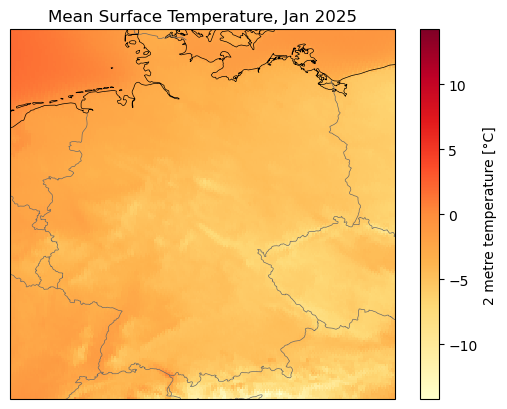

In [10]:
display.map(
    t2m_germany_area_january_2025_monthly_mean, 
    projection=crs.Miller(), 
    vmax=None, 
    cmap="YlOrRd", 
    title="Mean Surface Temperature, Jan 2025"
);

### 2 metre temperature climatology in Berlin, 2020-2035

The power of EDH is better showned when working with timeseries. We will now show how fast it is to compute the 2 metre temperature climatology (montly mean and standard deviation) in Berlin, over the reference period 2020-2035.

With legacy data distributon systems you would need to dowload the entire world temperature, for the reference time period, in order to extract the Berlin data. Thanks to earth data hub this is not needed anymore! you only need to download the relevant chunks.

Here, we select the closet data to Berlin:

In [11]:
t2m_Berlin_2020_2035 = t2m.sel(**{"latitude": 52.5, "longitude": 13.4}, method="nearest").sel(time=slice("2020", "2035"))
t2m_Berlin_2020_2035

<xarray.DataArray 't2m' (time: 140256)> Size: 561kB
dask.array<getitem, shape=(140256,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 8B 52.51
    longitude  float64 8B 13.4
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 1MB 2020-01-01 ... 2035-12-31T23:00:00
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           °C

In order to estimate the size of the download, we can use the _costing.py_ module:

In [12]:
import costing

costing.estimate_download_size(t2m, t2m_Berlin_2020_2035)     # you need to provide to the function both the original DataArray and your data selection 

estimated_needed_chunks: 2922
estimated_memory_size: 147.069 GB
estimated_download_size: 14.707 GB


This is already small enought to be computed.


In [13]:
%%time

t2m_Berlin_2020_2035_computed = t2m_Berlin_2020_2035.compute()

CPU times: user 5min 20s, sys: 3min 44s, total: 9min 5s
Wall time: 2min 48s


Now that the data is loaded in memory we can easily compute the climatology:

In [14]:
t2m_Berlin_climatology_mean = t2m_Berlin_2020_2035_computed.groupby("time.month").mean(dim="time")
t2m_Berlin_climatology_std = t2m_Berlin_2020_2035_computed.groupby("time.month").std(dim="time")

We can finally plot the climatology in Berlin for the 2020-2035 refrence period

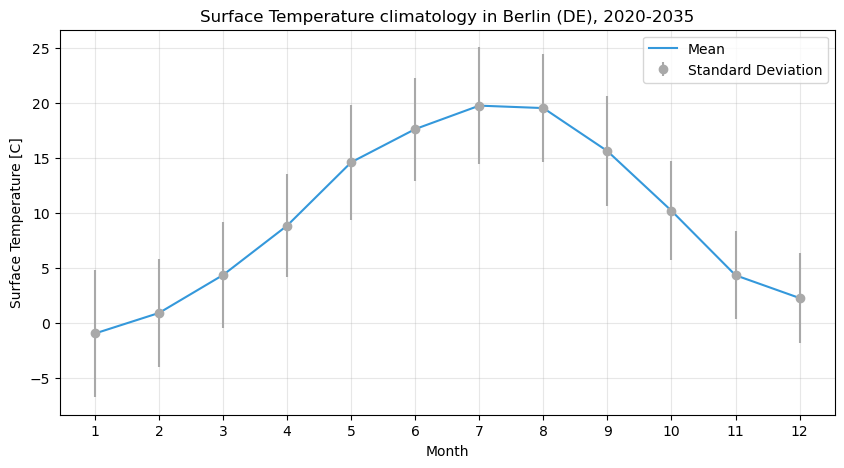

In [15]:
plt.figure(figsize=(10, 5))
t2m_Berlin_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_Berlin_climatology_mean.month, 
    t2m_Berlin_climatology_mean, 
    yerr=t2m_Berlin_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)

plt.title("Surface Temperature climatology in Berlin (DE), 2020-2035")
plt.xticks(t2m_Berlin_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()